# Trade off between S, Tmin, and Tmax

In this notebook we plot the master figure to show the trade off between S, tmin and tmax

2022.04.30 Kurama Okubo

2023.10.6 update notation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import time
import pickle
import h5py
import emcee # MCMC sampler
import corner
import copy
from scattermatrix import *
from MCMC_func import *

%matplotlib inline

# modules used for Low level callback function duting integration
import os, ctypes
from scipy import integrate, LowLevelCallable
import matplotlib.dates as dates
from matplotlib.gridspec import GridSpec

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["xtick.minor.size"] = 2
plt.rcParams["xtick.minor.width"] = 1
plt.rcParams["xtick.minor.visible"] = False # True


plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["ytick.minor.size"] = 2
plt.rcParams["ytick.minor.width"] = 1
plt.rcParams["ytick.minor.visible"] = True

os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion

In [2]:
output_imgdir = "../figure"
output_datadir = "../data"

if not os.path.exists(output_imgdir):
    os.makedirs(output_imgdir)
    
if not os.path.exists(output_datadir):
    os.makedirs(output_datadir)

In [3]:
starttime = datetime.datetime(2002, 1, 1)
endtime = datetime.datetime(2022, 6, 1)
vlines = [datetime.datetime(2003, 12, 12), datetime.datetime(2004, 9, 28)] 


# Define functions for log probability 

In [4]:
# Integration with low level callback function
# read shared library
lib_int = ctypes.CDLL(os.path.abspath('./LowLevel_callback_healing_distributed/healing_int.so'))
lib_int.f.restype = ctypes.c_double
lib_int.f.argtypes = (ctypes.c_int, ctypes.POINTER(ctypes.c_double), ctypes.c_void_p)
    
def logheal_llc(ts, S, taumin, taumax, lib_int):
    # using Low-level caling function
    # taumin = 0.1 # fix taumin so that healing starts just after incident
    c = ctypes.c_double(ts) # time t as void * userdata
    user_data = ctypes.cast(ctypes.pointer(c), ctypes.c_void_p)
    int1_llc = LowLevelCallable(lib_int.f, user_data) # in this way, only void* is available as argument

    return -S*integrate.quad(int1_llc, taumin, taumax, epsabs = 1e-3, epsrel=1e-3)[0] # this tolerance archieves our requirement in accuracy.

def y_heal_llc(t, S, taumin, taumax, unix_tEV, lib_int):
    
#     print(t, unix_tEV, t-unix_tEV)
    
    if t < unix_tEV:
        return 0
    else:
        # compute logheal model
        return logheal_llc(t-unix_tEV, S, taumin, taumax, lib_int)

In [5]:
# Apply constraint
S_range = [0, 0.6]
tmin_range = [1e-3, 1.0] # years
tmax_range = [0.7, 100] #[2, 100] # years

#---Log probabilities---#
def log_likelihood_PF(theta, **modelparam):
    #parse parameters
    S, tmin, tmax, log_f = theta
    unix_tvec = modelparam["unix_tvec"]
    uniform_tvec = modelparam["uniform_tvec"]
    dvv_model= [y_heal_llc(t, S, 10**tmin, 10**tmax, modelparam["unix_tPF"], lib_int) for t in unix_tvec]

    dvv_data = modelparam["dvv_data"]
    err_data  = modelparam["err_data"]
    
    # sigma2 = yerr_trim ** 2 + model ** 2 * np.exp(2 * log_f)
    sigma2 = err_data ** 2 + np.exp(2 * log_f) # 2022.2.21 Applying constant over/under estimation in error

#     #debug plot
#     plt.plot(uniform_tvec, dvv_data, "k-x", label = "data")
#     plt.plot(uniform_tvec, dvv_model, "r-o", label = "model")
#     plt.legend(loc=1)
#     plt.title(f"residu: {np.linalg.norm(dvv_data - dvv_model):.8f}")
    
    return -0.5 * np.nansum((dvv_data - dvv_model) ** 2 / sigma2 + np.log(sigma2)) # 2pi is ignored

# assign boundary of parammeters as prior probability
def log_prior_PF(theta, **modelparam):

    S, logtmin, logtmax, log_f = theta

    tmin = 10**logtmin
    tmax = 10**logtmax
    tmin_range_sec = np.array(tmin_range) *365*86400
    tmax_range_sec = np.array(tmax_range) *365*86400

    if (S<S_range[0]) or (S_range[1] < S): # We constrain 0<S<1.0 to avoid the large trade off between S, tmin and tmax
        return -np.inf
    
    if (tmin<tmin_range_sec[0]) or (tmin_range_sec[1] < tmin):
        return -np.inf
    
    if (tmax<tmax_range_sec[0]) or (tmax_range_sec[1] < tmax):
        return -np.inf
    
    if (tmin>tmax):
        return -np.inf
    
    if (-10.0 > log_f) or (log_f > -1.0):
        return -np.inf
    
    # if all the trial parameters are within the boundaries, return 0.
    return 0

def log_probability_PF(theta0, **modelparam):
    if len(theta0)==3:
        theta=np.concatenate((theta0[0], modelparam["tmin_fixed"], theta0[1:4]), axis=None)
    elif len(theta0)==4:
        theta = theta0 
    else:
        theta = theta0
    
    lp = log_prior_PF(theta, **modelparam)

    if not np.isfinite(lp):
        return -np.inf
    
    return lp + log_likelihood_PF(theta, **modelparam)


In [6]:
def rescale_chain(chain, caseid):
    """
    rescale time
    """
    if  len(chain.shape)==3:
        # chains are not flatten
        #log10time[s] -> log10time[year]
        if caseid==0:
            chain[:, :, 1] = np.log10(np.array([10**x/86400/365 for x in chain[:, :, 1]]))
        else:
            chain[:, :, 1] = np.log10(np.array([10**x/86400/365 for x in chain[:, :, 1]]))
            chain[:, :, 2] = np.log10(np.array([10**x/86400/365 for x in chain[:, :, 2]]))
        
    elif len(chain.shape)==2:
        # chains are flattern
        if caseid==0:
            chain[:, 1] = np.log10(np.array([10**x/86400/365 for x in chain[:, 1]]))
        else:
            chain[:, 1] = np.log10(np.array([10**x/86400/365 for x in chain[:, 1]]))
            chain[:, 2] = np.log10(np.array([10**x/86400/365 for x in chain[:, 2]]))
    else:
        raise ValueError("size of chain is unknown.") 

def rescale_theta(theta, caseid):
    if caseid==0:
        theta[1] = np.log10(10**theta[1]/86400/365)
    elif caseid==1:
        theta[1] = np.log10(10**theta[1]/86400/365)
        theta[2] = np.log10(10**theta[2]/86400/365)

# Load the master data


In [7]:
stationpair = "BP.VCAB-BP.VCAB"
dvvmethod = "mwcs"
freqband = "0.9-1.2"
modelcase = "wlin"
caseid = 1
nsteps = 10000

vlines = [datetime.datetime(2003, 12, 12), datetime.datetime(2004, 9, 28)] 


In [8]:
foname = f"{output_datadir}/tradeoff_Sandtmintmax_masterdata_{stationpair}_{dvvmethod}_{freqband}_{modelcase}_{caseid}_{nsteps}.pickle"
with open(foname, "rb") as f:
    sampler = pickle.load(f)
    masterplot_data = pickle.load(f)
    

In [9]:
masterplot_data.keys()

dict_keys(['stationpair', 'dvvmethod', 'freqband', 'modelcase', 'uniform_tvec', 'unix_tvec', 'unix_SS', 'unix_tPF', 'dvv_data', 'dvv_data_PF', 'xliimit_focus', 'fitting_period_ind', 'mcmc_discard_nsample', 'labels', 'S_range', 'tmin_range', 'tmax_range', 'cornerranges_x', 'cornerranges_y', 'cornerticks_x', 'cornerticks_y'])

In [10]:
stationpair = masterplot_data["stationpair"]
dvvmethod = masterplot_data["dvvmethod"]
freqband = masterplot_data["freqband"]
modelcase = masterplot_data["modelcase"]
uniform_tvec = masterplot_data["uniform_tvec"]
dvv_data = masterplot_data["dvv_data"]
dvv_data_PF = masterplot_data["dvv_data_PF"]

cornerranges_x = masterplot_data["cornerranges_x"]
cornerranges_y = masterplot_data["cornerranges_y"]
cornerticks_x = masterplot_data["cornerticks_x"]
cornerticks_y = masterplot_data["cornerticks_y"]


# Process for the variation of dv/v fitting

In [11]:
mcmc_discard_nsample = masterplot_data["mcmc_discard_nsample"]
chains_samples_flat =  sampler.get_chain(discard=mcmc_discard_nsample, thin=1, flat=True)
chains_lnprob_flat =  sampler.get_log_prob(discard=mcmc_discard_nsample, thin=1, flat=True)

In [12]:
probinds = np.argsort(chains_lnprob_flat)[::-1] # sort by log probability

In [13]:
numdvvtraces = 10000

In [14]:
S = []
tmin = []
tmax = []
logprob = []
logprob_ind = []
# assemble model parameters with higher probability
for probind in probinds[:numdvvtraces]:
    # probind = probinds[0]
    logprob0 = chains_lnprob_flat[probind]
    S0, tmin0, tmax0, _ = chains_samples_flat[probind, :]
    S.append(S0)
    tmin.append(tmin0)
    tmax.append(tmax0)
    logprob.append(logprob0)
    logprob_ind.append(probind)

In [15]:
df_modelparam = pd.DataFrame(np.transpose([S, tmin, tmax, logprob, logprob_ind]), columns=["S", "tmin", "tmax", "logprob", "logprob_ind"]).sort_values(by="S")
df_modelparam

,S,tmin,tmax,logprob,logprob_ind
9266,0.224505,7.290108,7.561839,557.156765,39332.0
9264,0.224505,7.290108,7.561839,557.156765,39348.0
9265,0.224505,7.290108,7.561839,557.156765,39380.0
9267,0.224505,7.290108,7.561839,557.156765,39316.0
9268,0.224505,7.290108,7.561839,557.156765,39268.0
...,...,...,...,...,...
6524,0.598782,7.397726,7.495139,557.213017,25549.0
6520,0.598782,7.397726,7.495139,557.213017,25341.0
3983,0.599426,7.355856,7.461542,557.272757,55020.0
3984,0.599426,7.355856,7.461542,557.272757,55004.0


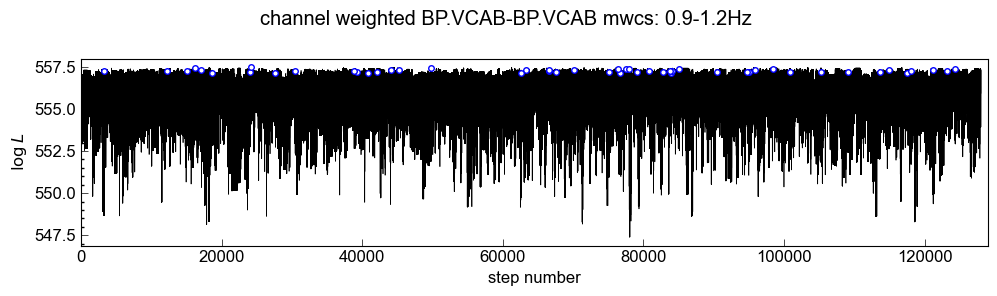

In [16]:
# plot logprob
# masterplot_data
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

ax.plot(chains_lnprob_flat, lw=0.5, c="k")


for i, row in df_modelparam.iterrows():
    if not i % 200 == 0:
        continue;
    ax.plot(row.logprob_ind, row.logprob, "o", markerfacecolor="w", markeredgecolor="b", ms=4)
    
# # plot maximum log probability
# plot_logprob = chain_log_prob_plot[:, lnprob_maxchain_id]

# ax = axes[-1]
# for i in range(chain_log_prob_plot.shape[1]):
#     ax.plot(chain_log_prob_plot[:, i], lw=0.5, c=lc[i, :], alpha=0.8);

# ax.axvline(mcmc_discard_nsample, c="k", ls="--")
# # plot the chain with maximum log probability
# ax.plot(plot_logprob, c="k", lw=lw_maxprob)
# ax.axhline(chain_log_prob_plot[max_logprob_ind+mcmc_discard_nsample, lnprob_maxchain_id], c="b", ls=":", lw=1.0)
# ax.plot(max_logprob_ind+mcmc_discard_nsample, maxprobval, "ro", ms=6, markeredgecolor="w");

ax.set_xlim([0, len(chains_lnprob_flat)+1000])
# ax.set_ylim(ylim_list[-1])
ax.set_ylabel("$\log{L}$")
ax.set_xlabel("step number");
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)

foname = (output_imgdir+f"/master_MCMC_alllogprob_{stationpair}_{dvvmethod}_{freqband}_{modelcase}_{caseid}.png")

fig.suptitle(f'channel weighted {stationpair} {dvvmethod}: {freqband}Hz')
fig.tight_layout(rect=[0,0,1,1])
plt.subplots_adjust(hspace=0.2)
fig.align_ylabels()

plt.savefig(foname, dpi=150, bbox_inches='tight')


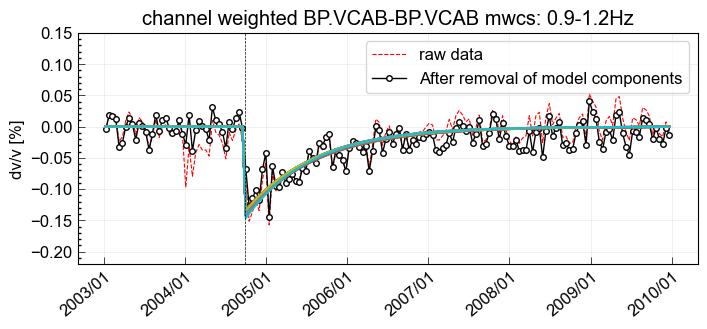

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
fitting_period_ind = masterplot_data["fitting_period_ind"]

ax.plot(uniform_tvec[fitting_period_ind], dvv_data[fitting_period_ind], "r--", lw=0.8, label="raw data")
ax.plot(uniform_tvec[fitting_period_ind], dvv_data_PF[fitting_period_ind], "ko-", lw=1, markerfacecolor="w", ms=4, label="After removal of model components")

plotstep = 200
for i, row in df_modelparam.iterrows():
    if not i % plotstep == 0:
        continue;
#     print(row.S, row.tmin, row.tmax)
    dvv_model= [y_heal_llc(t, row.S, 10**row.tmin, 10**row.tmax, masterplot_data["unix_tPF"], lib_int) for t in masterplot_data["unix_tvec"][fitting_period_ind]]
    ax.plot(masterplot_data["uniform_tvec"][fitting_period_ind], dvv_model)
    

ax.set_ylim(-0.22, 0.15)
ax.set_yticks(np.linspace(-0.20, 0.15, 8))
ax.set_ylabel("dv/v [%]")
# ax.set_xlim(xliimit_focus)
ax.grid(True, axis="both", lw=0.5, c=[0.8, 0.8, 0.8], alpha=0.4, zorder=-20)
    
ax.axvline(vlines[1], color='k', linewidth=0.5, linestyle='--', zorder=2)
ax.set_title(f"channel weighted {stationpair} {dvvmethod}: {freqband}Hz")
ax.legend(loc=1)

xfmt = dates.DateFormatter('%Y/%m')
ax.xaxis.set_major_formatter(xfmt) 
plt.setp(ax.get_xticklabels(), rotation=40, ha="right", rotation_mode="anchor")

foname = (output_imgdir+"/master_logheal_higherlogprob_{}_{}_{}_{}.png".format(stationpair, dvvmethod, freqband, modelcase))
plt.savefig(foname, dpi=150, bbox_inches='tight')

# Plot master figure

In [18]:
masterplot_data.keys()

dict_keys(['stationpair', 'dvvmethod', 'freqband', 'modelcase', 'uniform_tvec', 'unix_tvec', 'unix_SS', 'unix_tPF', 'dvv_data', 'dvv_data_PF', 'xliimit_focus', 'fitting_period_ind', 'mcmc_discard_nsample', 'labels', 'S_range', 'tmin_range', 'tmax_range', 'cornerranges_x', 'cornerranges_y', 'cornerticks_x', 'cornerticks_y'])

In [19]:
# Reassemble chains
chains_samples_all = copy.deepcopy(sampler.get_chain(discard=masterplot_data["mcmc_discard_nsample"], thin=1, flat=True))
rescale_chain(chains_samples_all, caseid)

datainds_trim = range(len(masterplot_data["labels"][:-1]))  #[0, 1, 2] #range(len(labels[:-1])) # plot all quantities
labels_trim=[masterplot_data["labels"][x] for x in datainds_trim]

## Plot dv/v traces

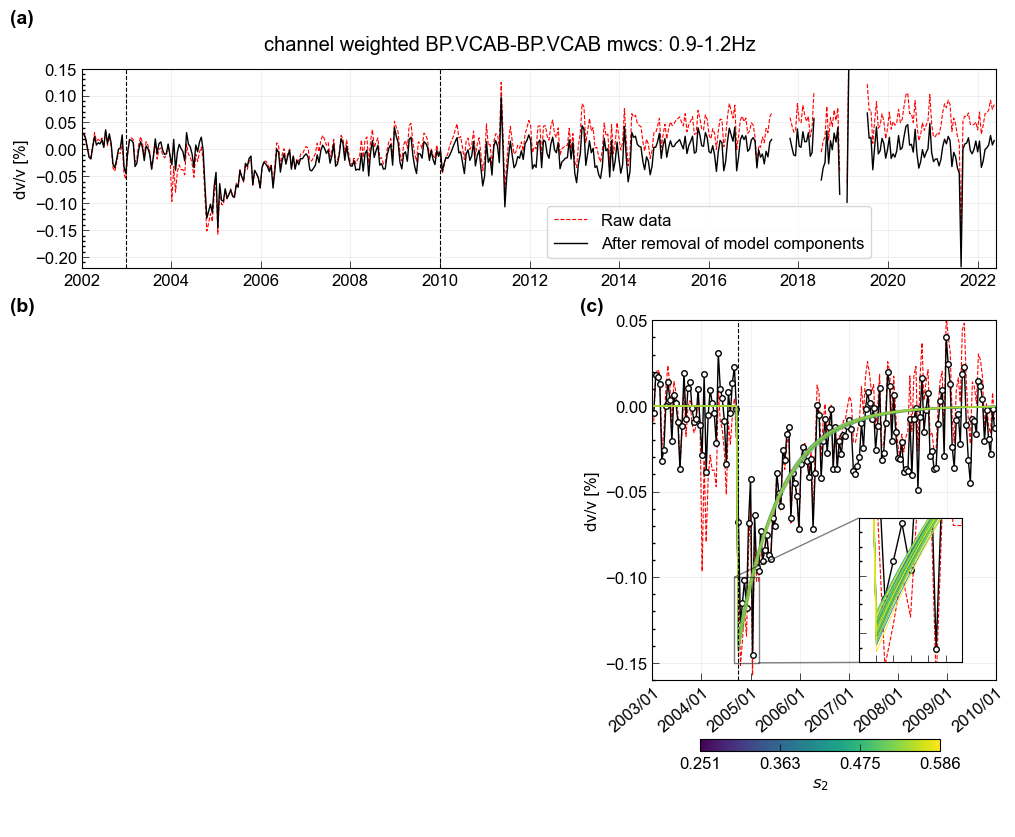

In [20]:
fig1 = plt.figure(constrained_layout=True, figsize=(10, 8))
gs1 = GridSpec(6, 7, figure=fig1)
gs1.update(hspace=0.2)
ax1 = plt.subplot(gs1[:2, :])
ax2 = plt.subplot(gs1[2:, :4])
ax3 = plt.subplot(gs1[2:5, 4:])

xfocus_range = masterplot_data["xliimit_focus"]

#---plot entire trace with and without removal---#
ax1.plot(uniform_tvec, dvv_data, "r--", lw=0.8, label="Raw data")
ax1.plot(uniform_tvec, dvv_data_PF, "k-", lw=1, label="After removal of model components")
xfmt = dates.DateFormatter('%Y')

ax1.set_ylim(-0.22, 0.15)
ax1.set_yticks(np.linspace(-0.20, 0.15, 8))
ax1.set_ylabel("dv/v [%]")
ax1.set_xlim(starttime, endtime)
ax1.grid(True, axis="both", lw=0.5, c=[0.8, 0.8, 0.8], alpha=0.4, zorder=-20)
ax1.legend(fontsize=12, bbox_to_anchor=(0.5, 0.35), bbox_transform=ax1.transAxes)

# vlines for figure 3
for xv in xfocus_range:
    ax1.axvline(xv, c="k", ls="--", lw=0.8)
    
#---plot scatter matrix---#
# we overlap the scatter matrix later as it plots in the independent figure handle
ax2.set_axis_off()

#---plot model fits---#
fitting_period_ind = masterplot_data["fitting_period_ind"]
ax3.plot(uniform_tvec[fitting_period_ind], dvv_data[fitting_period_ind], "r--", lw=0.8, label="raw data")
ax3.plot(uniform_tvec[fitting_period_ind], dvv_data_PF[fitting_period_ind], "ko-", lw=1, markerfacecolor="w", ms=4, label="After removal of model components")

plotstep = 200

# evaluate min and max S to define the range
S_list = []
for i, row in df_modelparam.iterrows():
    if not i % plotstep == 0:
        continue;
    S_list.append(row.S)    
        
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=np.min(S_list), vmax=np.max(S_list))

for i, row in df_modelparam.iterrows():
    if not i % plotstep == 0:
        continue;
#     print(row.S, row.tmin, row.tmax)
    dvv_model= [y_heal_llc(t, row.S, 10**row.tmin, 10**row.tmax, masterplot_data["unix_tPF"], lib_int) for t in masterplot_data["unix_tvec"][fitting_period_ind]]
    ax3.plot(masterplot_data["uniform_tvec"][fitting_period_ind], dvv_model, color=cmap(norm(row.S)), lw=1.0, alpha=0.2)
    
ax3.set_ylim(-0.16, 0.05)
ax3.set_yticks(np.linspace(-0.15, 0.05, 5))
ax3.set_ylabel("dv/v [%]")
ax3.set_xlim(xfocus_range)
ax3.grid(True, axis="both", lw=0.5, c=[0.8, 0.8, 0.8], alpha=0.4, zorder=-20)
    
ax3.axvline(vlines[1], color='k', linewidth=0.8, linestyle='--', zorder=2)

# plot inset
axins = ax3.inset_axes([0.6, 0.05, 0.3, 0.4])
axins.plot(uniform_tvec[fitting_period_ind], dvv_data[fitting_period_ind], "r--", lw=0.8, label="raw data")
axins.plot(uniform_tvec[fitting_period_ind], dvv_data_PF[fitting_period_ind], "ko-", lw=1, markerfacecolor="w", ms=4, label="After removal of model components")

for i, row in df_modelparam.iterrows():
    if not i % plotstep == 0:
        continue;
#     print(row.S, row.tmin, row.tmax)
    dvv_model= [y_heal_llc(t, row.S, 10**row.tmin, 10**row.tmax, masterplot_data["unix_tPF"], lib_int) for t in masterplot_data["unix_tvec"][fitting_period_ind]]
    axins.plot(masterplot_data["uniform_tvec"][fitting_period_ind], dvv_model, color=cmap(norm(row.S)), lw=0.6, alpha=1)

xinset_range = [datetime.datetime(2004, 9, 1), datetime.datetime(2005, 3, 1)]
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.set_xlim(xinset_range)
axins.set_ylim([-0.15, -0.1])
ax3.indicate_inset_zoom(axins, edgecolor="black")


cbar_ax = fig1.add_axes([0.66, 0.1, 0.3, 0.1])
cbar_ax.set_axis_off()
cbar=fig1.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                 orientation='horizontal', ax=cbar_ax, location = 'bottom',
                 label=r"$s_2$")

cbar.ax.set_xticks(np.round(np.linspace(np.min(S_list), np.max(S_list), 4), 3))

xfmt = dates.DateFormatter('%Y/%m')
ax3.xaxis.set_major_formatter(xfmt) 
plt.setp(ax3.get_xticklabels(), rotation=40, ha="right", rotation_mode="anchor")


# annotate figure id
plt.text(0.0, 1.01, "(a)", fontsize=14, fontweight="bold", transform=plt.gcf().transFigure)
plt.text(0.0, 0.65, "(b)", fontsize=14, fontweight="bold", transform=plt.gcf().transFigure)
plt.text(0.57, 0.65, "(c)", fontsize=14, fontweight="bold", transform=plt.gcf().transFigure)

fig1.suptitle(f'channel weighted {stationpair} {dvvmethod}: {freqband}Hz')

foname = (output_imgdir+"/master_tradeoffofStmintmax_{}_{}_{}_{}.png".format(stationpair, dvvmethod, freqband, modelcase))
plt.savefig(foname, dpi=150, bbox_inches='tight')


## Plot scatter matrix

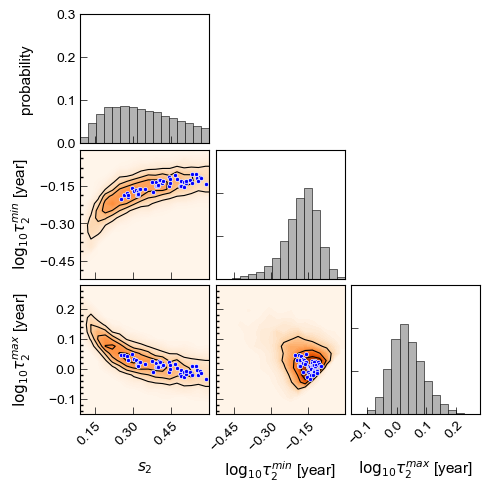

In [21]:
masterplot_data["nbin_hist"] = 16

# flat_samples_maxprob

fig0, axs, sm = plot_scattermatrix(chains_samples_all, datainds_trim, labels_trim, left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05,
    xrange_sigma_factor=2, bincolorgray=0.7, nbin_hist=masterplot_data["nbin_hist"], nbin_hist2d=18, Ncontourf=51, Ncontour=5, Ncontour_clip=4, cmap="Oranges",
    xticks=cornerticks_x, yticks=cornerticks_y, plot_truth=False,
    ylim_max=0.3, zlim_max=0.04, xranges=cornerranges_x, plot_median=False, plot_bestparam= None, labelfontsize=11, tickfontsize=10, figsize=(5, 5));

fig0.align_labels();
# fig0.suptitle(f'channel weighted {stationpair} {dvvmethod}: {freqband}Hz')
# plt.subplots_adjust(top=0.9)

# Plot set of model parameters on the 2d histogram
for i, row in df_modelparam.iterrows():
    if not i % plotstep == 0:
        continue;
    S0 = row.S
    tmin0 = np.log10(10**row.tmin/86400/365)
    tmax0 = np.log10(10**row.tmax/86400/365)
    axs[1, 0].plot(S0, tmin0, "o", ms=3, markerfacecolor="b", markeredgecolor="w", markeredgewidth=0.5, alpha=1)
    axs[2, 0].plot(S0, tmax0, "o", ms=3, markerfacecolor="b", markeredgecolor="w", markeredgewidth=0.5, alpha=1)
    axs[2, 1].plot(tmin0, tmax0, "o", ms=3, markerfacecolor="b", markeredgecolor="w", markeredgewidth=0.5, alpha=1)

foname = (output_imgdir+f"/master_MCMC_tradeoff_Sandtmintmax_scattermatrix_{stationpair}_{dvvmethod}_{freqband}_{masterplot_data['modelcase']}_{caseid}_{nsteps}.png")
plt.savefig(foname, dpi=150, bbox_inches='tight')

# Conclusion

This plot show the trade-off between S, tmin and tmax. The different parameter set of them provides nealy identical dv/v model as shown in figure (c). Therefore, we need to update the model formulation to obtain better constraint in the parameters associated with the healing model.